# Visualizing Processed Labels
This notebook takes analyzes processed labels to ensure consistency.

In [1]:
!pip install seaborn -q
!pip install altair -q

In [11]:
from datetime import timedelta
from shapely.geometry import Point
from pathlib import Path
from tqdm.notebook import tqdm
import altair as alt
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pprint
import sys
sys.path.append("..")

from utils import get_dvc_dir
from src.datasets_labeled import labeled_datasets
from src.ETL.dataset import DataDir
from src.ETL.constants import LAT, LON

# Read in data

In [5]:
test_dir = get_dvc_dir("test")
africa = geopandas.read_file(test_dir / "afr_g2014_2013_0")

In [50]:
get_dvc_dir("processed")
df = pd.concat([pd.read_csv(d.get_path(DataDir.LABELS_PATH)) for d in labeled_datasets])

In [54]:
counts = []

for subset in df['subset'].unique():
    series = df[df['subset'] == subset]['country'].value_counts().rename(subset)
    counts.append(series)

total = df['country'].value_counts().rename("Total")
counts.append(total)

counts_df = pd.concat(counts, axis=1)

# Each dataset should have at least validation and testing 525
counts_df['Ready for eval'] = (counts_df['validation'] > 525) & (counts_df['testing'] > 525)
counts_df

,training,validation,testing,Total,Ready for eval
global,28724,7142,NaN,35866,False
Kenya,6914,861,884.0,8659,True
Togo,999,277,355.0,1631,False
Mali,713,107,77.0,897,False
Rwanda,287,538,540.0,1365,True
Uganda,125,536,539.0,1200,True


In [154]:
df[(df['country'] == 'Uganda') & (df['subset'] == 'training')]

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country
0,29.127404,-1.495906,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda
1,29.127583,-0.143896,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda
2,29.127583,0.725922,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda
4,29.128661,-0.879863,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda
5,29.128841,-0.387490,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda
...,...,...,...,...,...,...,...,...,...
1193,35.172965,-0.757178,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.5,2,training,Uganda
1195,35.173864,3.428613,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda
1196,35.174223,3.189727,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda
1197,35.174223,3.804756,2019-04-22,2020-04-16,ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample...,0.0,2,training,Uganda


In [160]:
df[(df['country'] == 'Kenya') & (df['subset'] == 'testing')]['crop_probability'].value_counts()

1.0    612
0.0    272
Name: crop_probability, dtype: int64

In [156]:
df[(df['country'] == 'Uganda') & (df['subset'] == 'testing')]['crop_probability'].value_counts()

0.0    89
1.0    20
0.5    19
Name: crop_probability, dtype: int64

# Checking Label Distributions

In [157]:
df["geometry"] = [Point(xy) for xy in zip(df["lon"], df["lat"])]
df.head()

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,country,geometry
0,-179.750000,71.452381,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-179.75 71.45238095000001)
1,-175.047619,-19.750000,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-175.047619 -19.75)
2,-172.250000,-13.547619,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-172.25 -13.54761905)
3,-164.750000,62.452381,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,validation,global,POINT (-164.75 62.45238095)
4,-163.250000,62.452381,2017-03-28,2018-03-28,loc_all_2.txt,0.0,1,training,global,POINT (-163.25 62.45238095)


In [158]:
def plot_country_specific_labels(df, hue):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.countplot(ax=ax, data=df, x='country', hue=hue)
    sns.despine()
    ax.set_title(f"Country Specific Labels Distribution by {hue}");

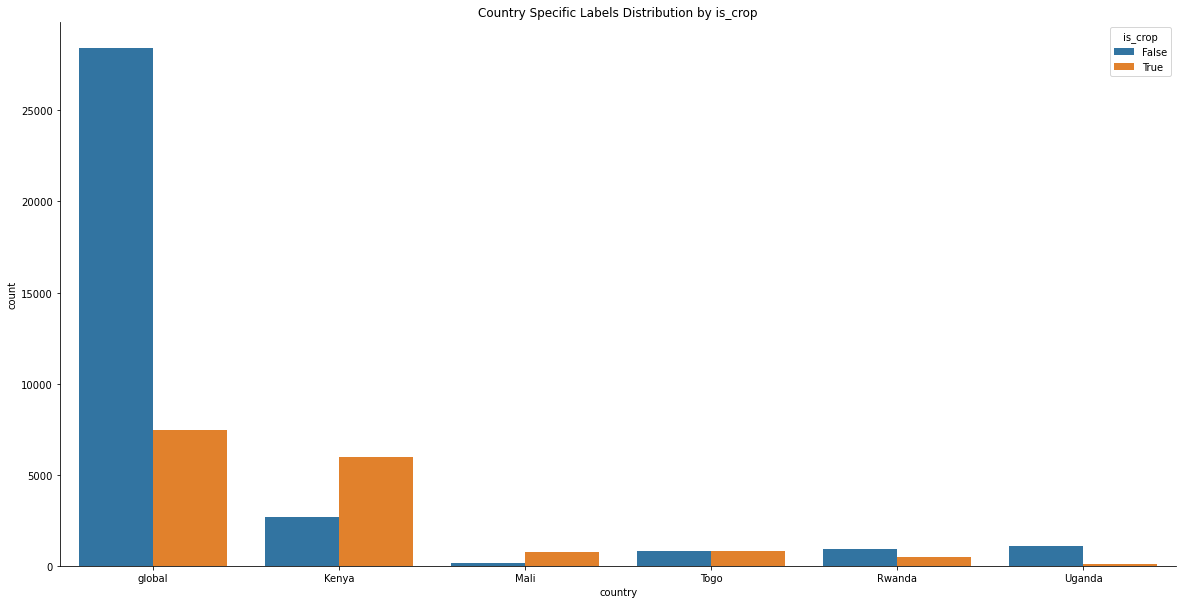

In [159]:
df["is_crop"] = df["crop_probability"] > 0.5 
plot_country_specific_labels(df, "is_crop")

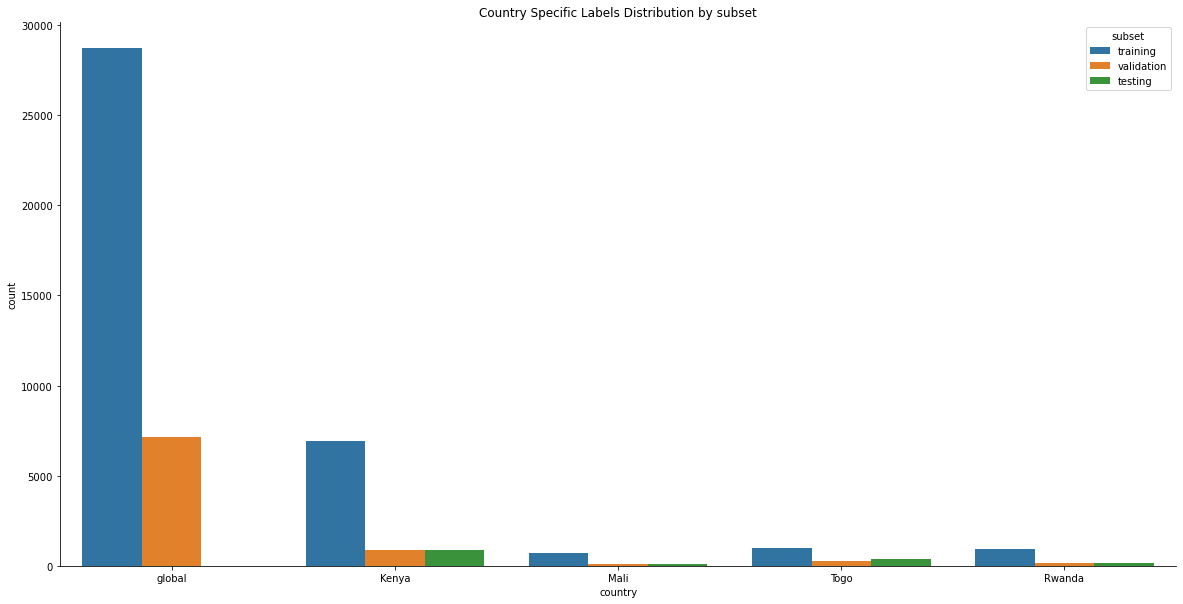

In [24]:
plot_country_specific_labels(df, "subset")

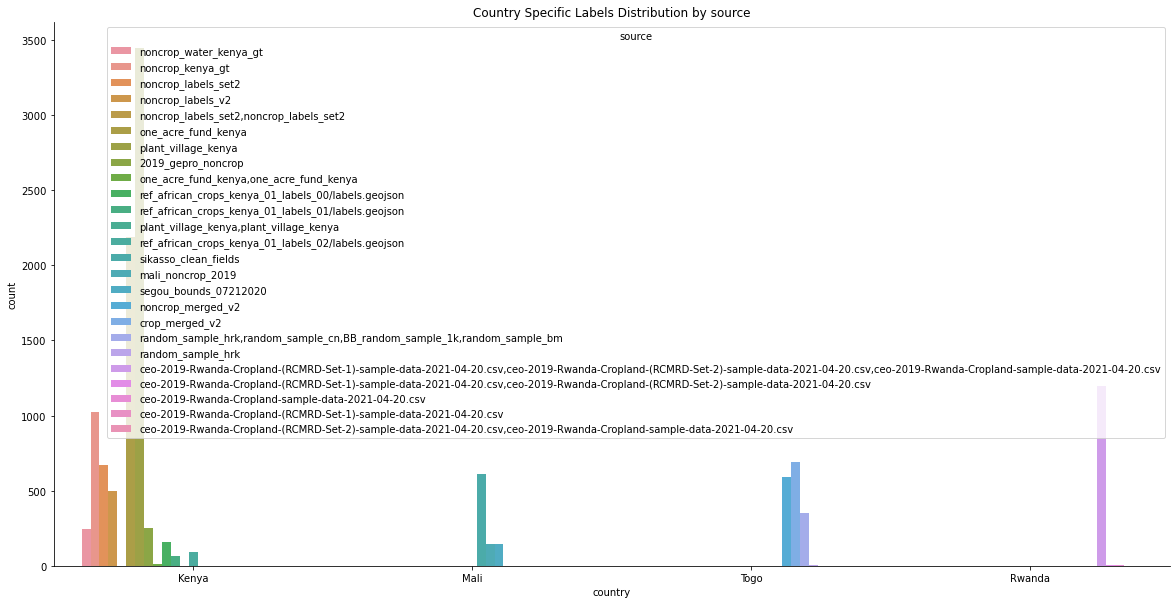

In [25]:
plot_country_specific_labels(df[df["country"] != "global"], "source")

In [28]:
df_non_global = geopandas.GeoDataFrame(df[df['country'] != "global"])

def within_country(point: Point, country: str, pbar):
    pbar.update(1)
    return point.within(africa[africa["ADM0_NAME"] == country]["geometry"].iloc[0])


with tqdm(total=len(df_non_global)) as pbar:
    df_non_global["point_within_country"] = np.vectorize(within_country)(df_non_global["geometry"], df_non_global["country"], pbar)

  0%|          | 0/12399 [00:00<?, ?it/s]

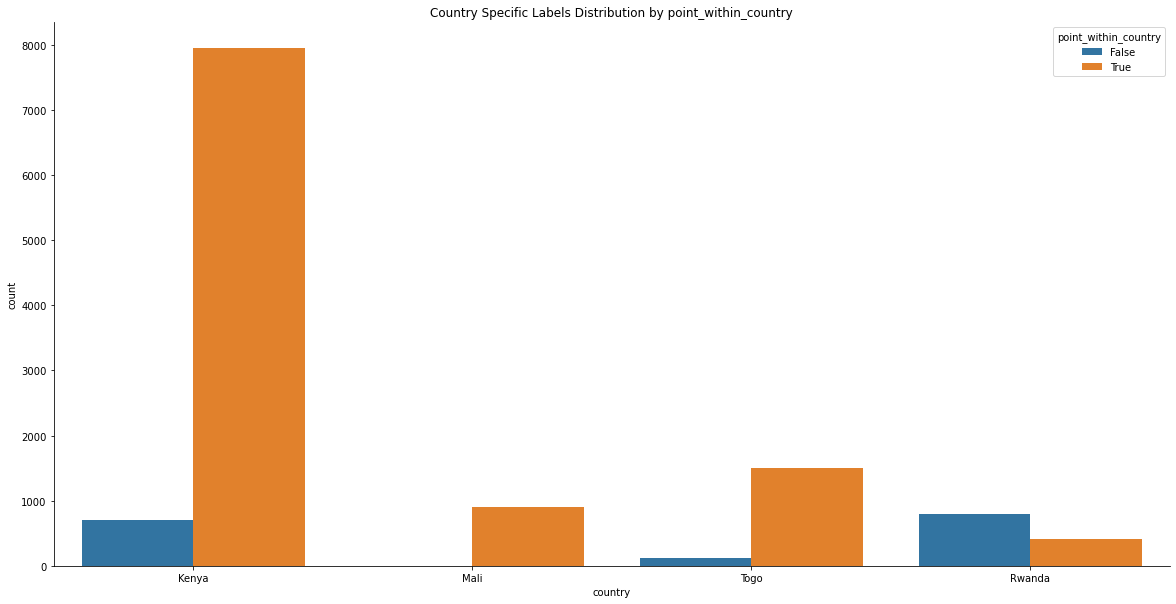

In [29]:
plot_country_specific_labels(df_non_global, "point_within_country")

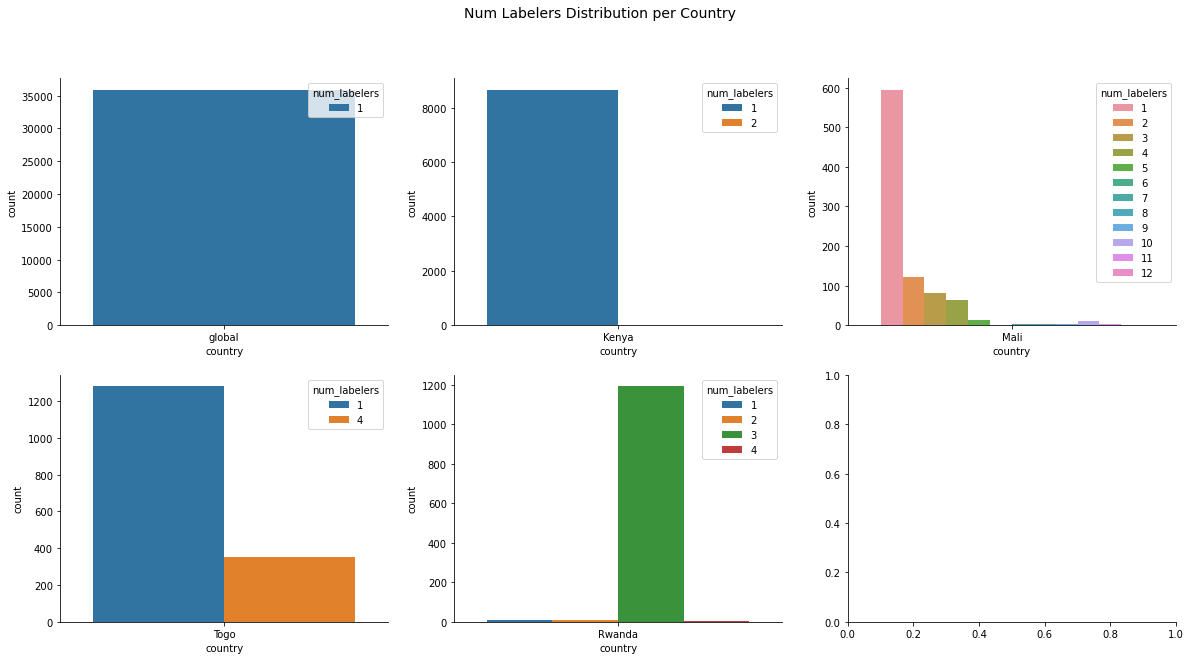

In [79]:
countries = df['country'].unique()
nrows = 2
ncols = int(np.ceil(len(countries)/nrows))
fig, ax = plt.subplots(figsize=(20,10), nrows=nrows, ncols=ncols)
k = 0
for i in range(nrows):
    for j in range(ncols):
        sns.countplot(ax=ax[i][j], data=df[df['country'] == countries[k]], x='country', hue='num_labelers')
        k += 1
        if k == len(countries):
            break
sns.despine()
plt.suptitle("Num Labelers Distribution per Country", fontsize=14);

In [41]:
df_non_global['country_and_source'] = (df_non_global['country'] + "/" + df_non_global['source']).str[:50]

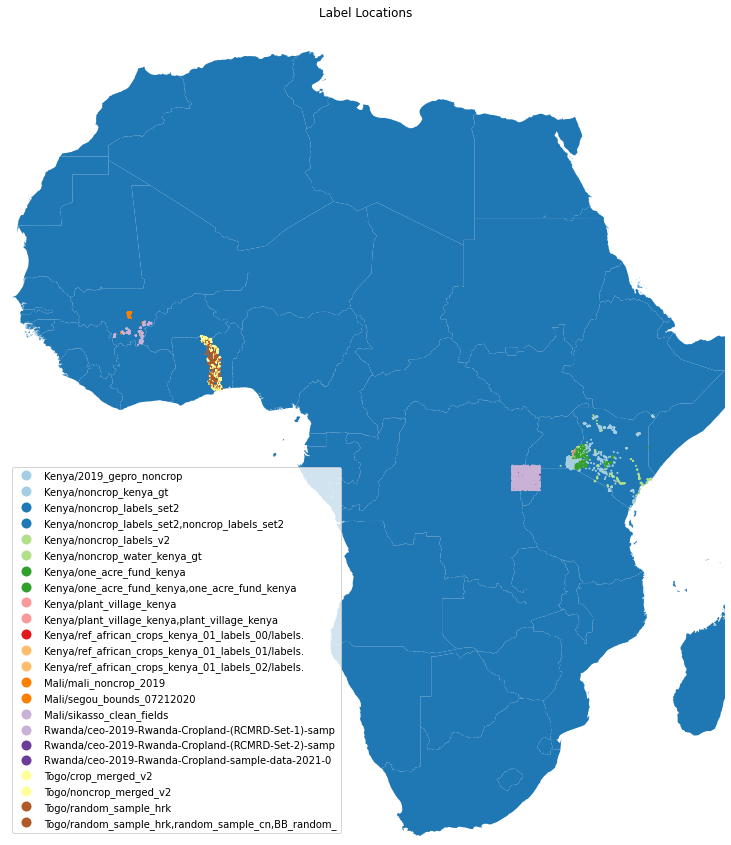

In [42]:
ax=africa.plot(figsize=(15,15))
ax.set_xlim(-18, 48)
ax.set_ylim(-35, 40)
ax.set_title("Label Locations")
ax.axis('off')
df_non_global.plot(
    ax=ax, 
    marker='o', 
    column='country_and_source', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True,
    legend_kwds={'loc': 'lower left'});

## Checking Plant Village Kenya data

In [47]:
sources = [f"ref_african_crops_kenya_01_labels_0{i}/labels.geojson" for i in [0,1,2]] + ["plant_village_kenya"]
df_new_pv = df[df['source'].isin(sources)] 

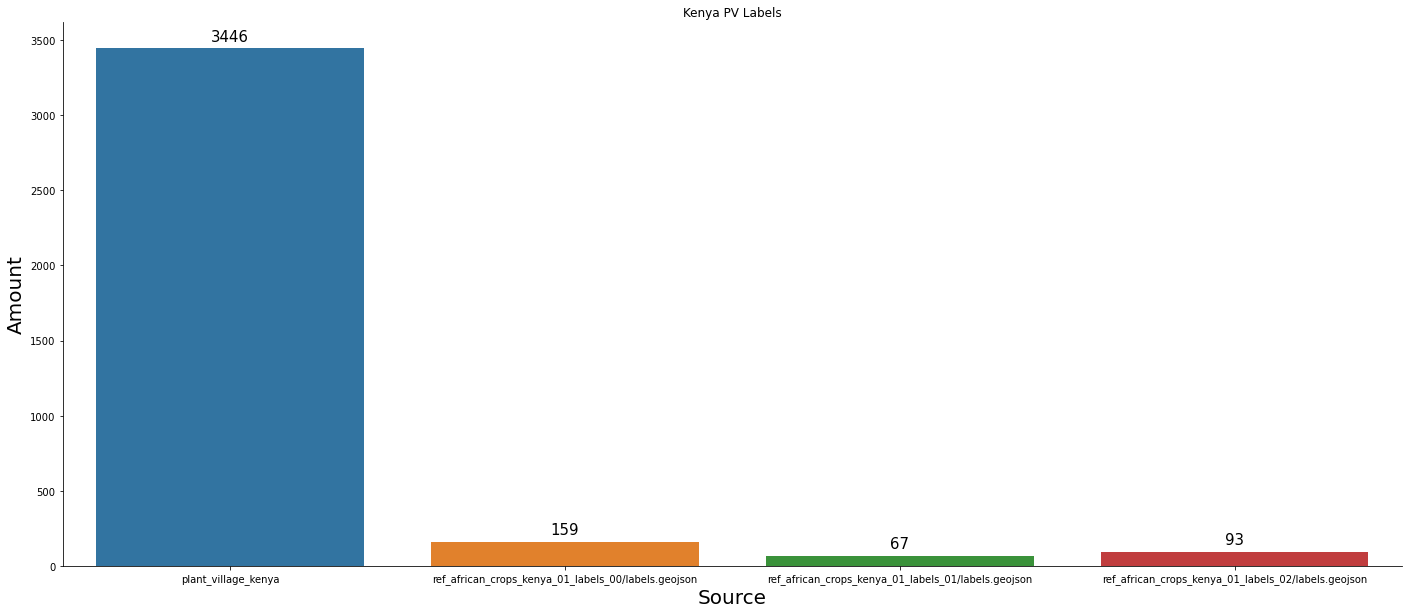

In [48]:
fig, ax = plt.subplots(figsize=(24,10))
sns.countplot(ax=ax, data=df_new_pv, x='source')
sns.despine()
ax.set_title(f"Kenya PV Labels")
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+50), size=15, ha='center')
    
ax.set_xlabel('Source',fontsize=20);
ax.set_ylabel('Amount',fontsize=20);

<AxesSubplot:title={'center':'Kenya Plant Village Label Locations'}>

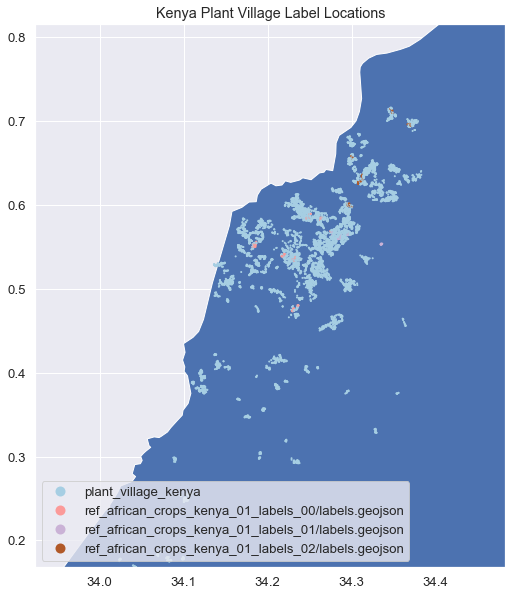

In [384]:
ax=africa[africa['ADM0_NAME'] == 'Kenya'].plot(figsize=(10,10))
ax.set_title("Kenya Plant Village Label Locations")
ax.set_xlim(df_new_pv['lon'].min() - 0.1, df_new_pv['lon'].max() + 0.1)
ax.set_ylim(df_new_pv['lat'].min(), df_new_pv['lat'].max() + 0.1)
geopandas.GeoDataFrame(df_new_pv).plot(
    ax=ax, 
    marker='o', 
    column='source', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True,
    legend_kwds={'loc': 'lower left'})

# Checking Export Date Ranges

In [9]:
date_ranges = df[['start_date', 'end_date', 'source', 'country']].drop_duplicates()

In [10]:
alt.Chart(date_ranges).mark_bar().encode(
    x='start_date',
    x2='end_date',
    y='source'
)

alt.Chart(...)

# Investigating Kenya PV Date Ranges

In [36]:
pv_df = geopandas.read_file(labeled_datasets[1].raw_labels_dir / "plant_village_kenya")

In [37]:
pv_df = pv_df[(pv_df["harvest_da"] != "nan") & (pv_df["harvest_da"] != "unknown")].copy()
len(pv_df)

8278

In [38]:
pv_df['planting_d'] = pd.to_datetime(pv_df['planting_d'])
pv_df['harvest_da'] = pd.to_datetime(pv_df['harvest_da'])
pv_df['between_days'] = (pv_df['harvest_da'] - pv_df['planting_d']).dt.days
pv_df['valid'] = (0 < pv_df['between_days']) & (pv_df['between_days'] < 365)
pv_df['planting_d_str'] = pv_df['planting_d'].dt.strftime("%Y-%m-%d")
pv_df['harvest_da_str'] = pv_df['harvest_da'].dt.strftime("%Y-%m-%d")
pv_df['range'] = pv_df['planting_d_str'] + "_" + pv_df['harvest_da_str']
pv_df.head()

,crop_type,planting_d,harvest_da,density,faw_preval,area,geometry,between_days,valid,planting_d_str,harvest_da_str,range
0,cassava,2018-11-15,2019-01-08,60,0,1010.878746,"POLYGON ((631201.321 61254.609, 631167.878 613...",54,True,2018-11-15,2019-01-08,2018-11-15_2019-01-08
1,intercrop_other,2019-08-08,2020-01-04,60,0,2138.274445,"POLYGON ((631127.970 61218.697, 631095.382 612...",149,True,2019-08-08,2020-01-04,2019-08-08_2020-01-04
2,maize,2019-07-17,2019-01-12,80,3,1021.751644,"POLYGON ((631079.546 61273.780, 631104.387 612...",-186,False,2019-07-17,2019-01-12,2019-07-17_2019-01-12
3,intercrop_maize,2019-07-26,2019-01-12,80,2,5845.948064,"POLYGON ((631316.357 61568.269, 631249.894 616...",-195,False,2019-07-26,2019-01-12,2019-07-26_2019-01-12
4,intercrop_maize,2019-01-08,2019-01-12,80,None,3821.957762,"POLYGON ((631426.161 61595.745, 631425.975 615...",4,True,2019-01-08,2019-01-12,2019-01-08_2019-01-12


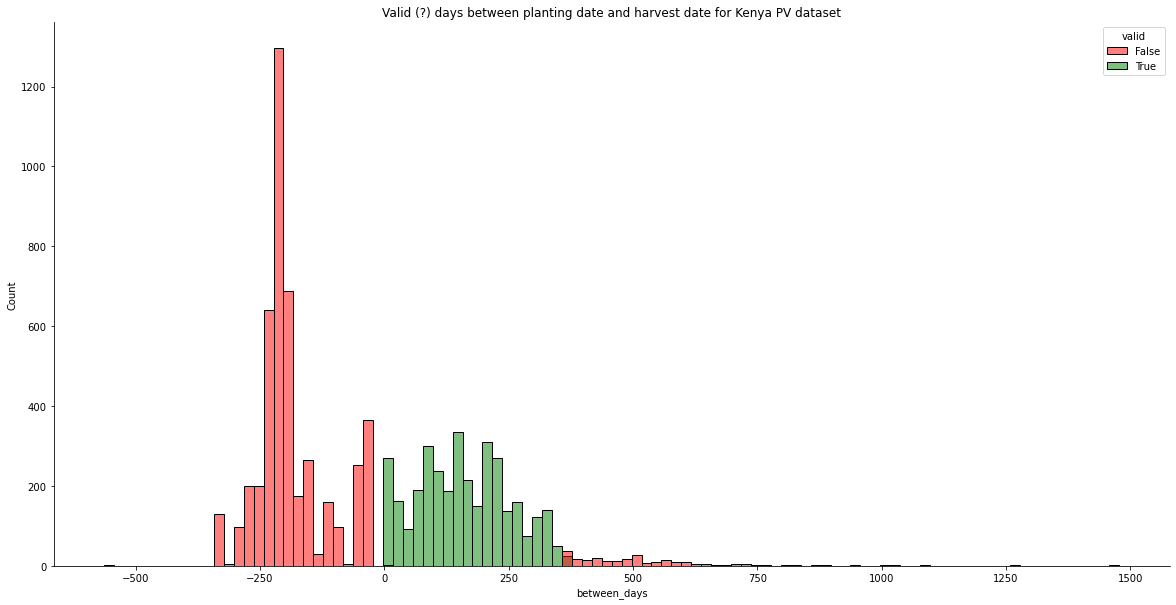

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=pv_df, x='between_days', ax=ax, hue='valid', palette=["red", "green"], binwidth=20)
sns.despine()
ax.set_title("Valid (?) days between planting date and harvest date for Kenya PV dataset");

In [40]:
# Remove invalid years
valid_years = [2018, 2019, 2020]
pv_df = pv_df[(pv_df["planting_d"].dt.year.isin(valid_years)) & (pv_df["harvest_da"].dt.year.isin(valid_years))].copy()
len(pv_df)

8167

In [42]:
pv_df["harvest_da"].dt.year.unique()

array([2019, 2020, 2018])

In [44]:
year = pd.to_timedelta(timedelta(days=365))

# if 0 > between days > -365, increase harvest_da year
mask = (pv_df['between_days'] < 0) & (pv_df['between_days'] > -365)
pv_df.loc[mask, 'harvest_da'] += year

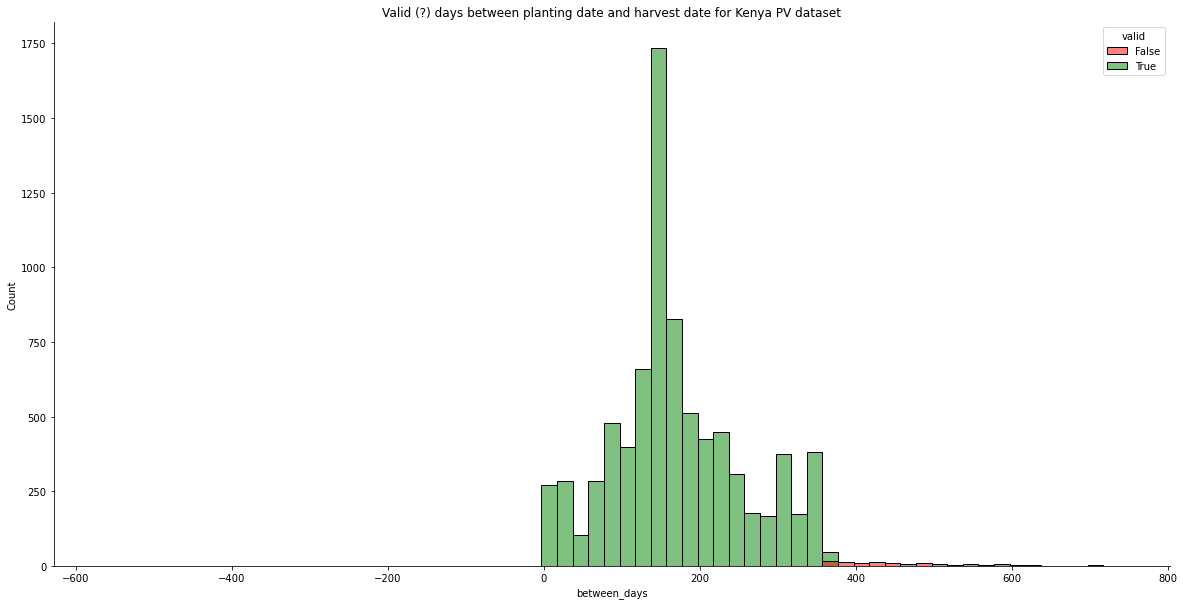

In [45]:
pv_df['between_days'] = (pv_df['harvest_da'] - pv_df['planting_d']).dt.days
pv_df['valid'] = (0 < pv_df['between_days']) & (pv_df['between_days'] <= 365)

fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=pv_df, x='between_days', ax=ax, hue='valid', palette=["red", "green"], binwidth=20)
sns.despine()
ax.set_title("Valid (?) days between planting date and harvest date for Kenya PV dataset");

In [18]:
pv_df['planting_d'].dt.year.unique()

array([2018, 2019, 2017, 2016, 2015])

In [19]:
pv_df['planting_d'].dt.year.value_counts()

2019    7464
2018     773
2017      38
2016       2
2015       1
Name: planting_d, dtype: int64

In [20]:
pv_df['harvest_da'].dt.year.value_counts()

2020    7187
2019    1048
2018      41
2021       1
2017       1
Name: harvest_da, dtype: int64

In [21]:
pv_df[pv_df['harvest_da'].dt.year == 2021]

,crop_type,planting_d,harvest_da,density,faw_preval,area,geometry,between_days,valid,planting_d_str,harvest_da_str,range
7562,intercrop_other,2019-01-08,2021-01-07,90,0,7026.53659,"POLYGON ((646628.009 58937.731, 646588.059 588...",730,False,2019-01-08,2021-01-07,2019-01-08_2021-01-07
